In [245]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [246]:
import pandas as pd
import geopandas as gpd
import xgboost
import sys
from sklearn.preprocessing import LabelEncoder
import numpy as np
from math import * 
from tqdm import tqdm
from sklearn import model_selection
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import f1_score
from sklearn.cluster import DBSCAN, OPTICS
from xgboost import XGBClassifier
from sklearn.preprocessing import PolynomialFeatures

import json
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 100
plt.style.use('dark_background')

from utils import plot_cluster, load_list, save_list, load_data, load_data_test


In [348]:
X, Y = load_data(add_knn_mean=True,
                 add_knn_concat=True,
                 add_dates=True,
                 add_polynomial=False,
                 n_data_max=9999999999,
                 shuffle = False)

X_target = load_data_test(add_knn_mean=True,
                 add_knn_concat=True,
                 add_dates=True,
                 n_data_max=99999999,
                 shuffle = False)

print(f'Datas containing NA loaded: {len(X[X.isna().any(axis = 1)])}')


Loading data...

Basic features lenght: 310006
knn mean features lenght: 5000
knn concat features lenght: 5000
Dates features lenght: 310006
X_train and Y_train loaded.
Loading data...

Basic features lenght: 121704
knn mean features lenght: 5000
knn concat features lenght: 5000
Dates features lenght: 121704
X_val loaded.
Datas containing NA loaded: 305006


In [ ]:
print(X.shape)
print(Y.shape)
print(X_target.shape)

(1000, 134)
(1000,)
(121704, 119)


In [334]:
print(list(X.columns))

['change_status_date1', 'change_status_date2', 'change_status_date3', 'change_status_date4', 'change_status_date5', 'diff1', 'diff2', 'diff3', 'diff4', 'season_date1', 'season_date2', 'season_date3', 'season_date4', 'season_date5', 'year_date1', 'year_date2', 'year_date3', 'year_date4', 'year_date5', 'area', 'length', 'area/length**2', 'elongation', 'centroid_x', 'centroid_y', 'height', 'width', 'nb_points', 'diff_area', 'is_convex', 'centroid_dist', 'length/width', 'Dense Urban', 'Industrial', 'None', 'Rural', 'Sparse Urban', 'Urban Slum', 'Barren Land', 'Coastal', 'Dense Forest', 'Desert', 'Farms', 'Grass Land', 'Hills', 'Lakes', 'None.1', 'River', 'Snow', 'Sparse Forest', 'knn_mean_area', 'knn_mean_length', 'knn_mean_area/length**2', 'knn_mean_elongation', 'knn_mean_centroid_x', 'knn_mean_height', 'knn_mean_width', 'knn_mean_nb_points', 'knn_mean_centroid_dist', 'knn_mean_length/width', 'knn_mean_Dense Urban', 'knn_mean_Industrial', 'knn_mean_None', 'knn_mean_Rural', 'knn_mean_Spars

Fitting...
Train score: 0.9733643589989722
Test score: 0.8842014652014655

Train score: 0.9771040296052632
Test score: 0.8585483870967743

Train score: 0.9770995406549869
Test score: 0.8787325268674329

Train score: 0.9797146371176625
Test score: 0.8928888888888891

Train score: 0.980999631208308
Test score: 0.8842432631967516

Train score: 0.9783862658572255
Test score: 0.8787325268674329



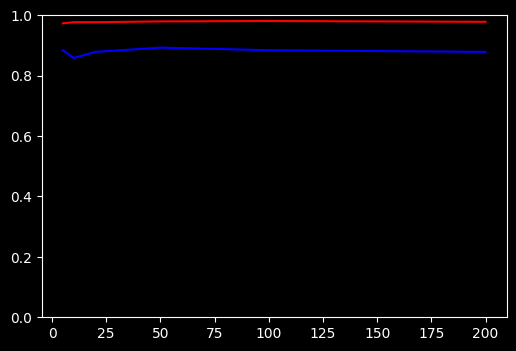

In [339]:

# xgb = XGBClassifier()

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, random_state = 22)

print('Fitting...')
L_n = [5, 10, 20, 50, 100, 200]
L_d = [2, 3, 4, 5, 10]
average = 'weighted'
L_train_score = list()
L_test_score = list()
L = list()

for n in L_n:
        model = RandomForestClassifier(n_estimators=n,
                            max_depth=12,
                            min_samples_leaf=1,
                            min_samples_split=2,
                                )
        # model = GradientBoostingClassifier(n_estimators=n, 
        #                         )
        # model = XGBClassifier( 
        #                 n_estimators = n,
        #         #       scale_pos_weight=1,
        #         #       learning_rate=0.01,  
        #         #       colsample_bytree = 0.4,
        #         #       subsample = 0.8,
        #         #       objective='binary:logistic', 
        #         #       reg_alpha = 0.3,
        #                 max_depth=8, 
        #         #       gamma=10,
        #                 use_label_encoder=False,
        #               )
        
        eval_set = [(X_train, Y_train), (X_test, Y_test)]
        eval_metric = ["error"]
        model.fit(X_train, Y_train, 
                # eval_metric=eval_metric, 
                # eval_set=eval_set, 
                # verbose=False
                  )
        
        Y_pred          = model.predict(X_test)
        Y_pred_train    = model.predict(X_train)
        score_train = f1_score(Y_train, Y_pred_train, average = average)
        score_test = f1_score(Y_test, Y_pred, average = average)
        L_train_score.append(score_train)
        L_test_score.append(score_test)
        L.append(n)
        print(f"Train score: {score_train}")
        print(f"Test score: {score_test}")
        print()
        plt.clf()
        plt.plot(L, L_train_score, 'r')
        plt.plot(L, L_test_score, 'b')
        plt.ylim(bottom = 0, top = 1)



In [312]:
importances = model.feature_importances_
for feature, imp in sorted(zip(X_train.columns, importances), key = lambda x: -x[1]):
    print(f'Importance of {feature}: {100*round(imp, 3)}%')

Importance of change_status_date5: 15.199999511241913%
Importance of change_status_date1: 6.1000000685453415%
Importance of knn_mean_area/length**2: 3.099999949336052%
Importance of centroid_y: 2.500000037252903%
Importance of area/length**2: 2.199999988079071%
Importance of change_status_date2: 2.0999999716877937%
Importance of centroid_dist: 1.899999938905239%
Importance of knn_mean_area: 1.7000000923871994%
Importance of knn_mean_centroid_x: 1.3000000268220901%
Importance of change_status_date4: 1.3000000268220901%
Importance of year_date2: 1.3000000268220901%
Importance of nb_points: 1.2000000104308128%
Importance of 1th_nn_centroid_x: 1.2000000104308128%
Importance of length: 1.2000000104308128%
Importance of change_status_date3: 1.0999999940395355%
Importance of height: 1.0999999940395355%
Importance of knn_mean_Industrial: 1.0999999940395355%
Importance of 1th_nn_year_date3: 1.0999999940395355%
Importance of knn_mean_Desert: 0.8999999612569809%
Importance of 1th_nn_year_date2: 0

In [322]:

def compress_outliers_on_test(X):
    '''Replace outliers geographically data points of test (plot test data to see what it means) to an area where they could be i guess.
    '''
    X[46053:47903]['centroid_y'] = (X[46053:47903]['centroid_y'] - 60) / (60/0.03) + 30
    return X

def sabotage(Y, frac = .5):
    N = int(frac * len(Y))
    Y[:N] = 5
    return Y

In [ ]:
X_target = compress_outliers_on_test(X_target)
Y_pred2submit = model.predict(X_target)
Y_pred2submit = sabotage(Y_pred2submit, 0.5)
# Save results to submission file
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission.csv", index=True, index_label='Id')

In [342]:
Y_pred2submit = sabotage(Y_pred2submit, frac = 1)
pred_df = pd.DataFrame(Y_pred2submit, columns=['change_type'])
pred_df.to_csv("submission2.csv", index=True, index_label='Id')

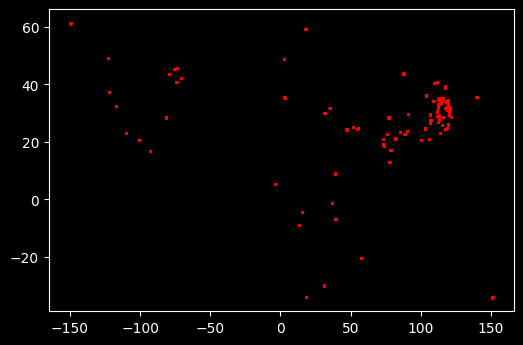

In [119]:
plot_cluster(X)